## Importiere `pandas`, `matplotlib`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
from datetime import datetime as dt
import locale
from scipy.interpolate import interp1d
from configparser import ConfigParser
from functions import *

## Lade die Konfigurationen aus `config.ini`
#### Definiere die Umgebung

In [2]:
config = ConfigParser()
files = config.read('config.ini')

In [3]:
locale = locale.setlocale(locale.LC_TIME, "de_DE")

In [4]:
env = 'test'
database_file = config.get(env, 'database_file')
date_begin = config.get(env, 'date_begin')
date_end = config.get(env, 'date_end')
target = ["Covid-19-Pandemie", "Ukraine-Krieg"]
#target = ["Proteste im Iran", "Covid-19-Pandemie", "Ukraine-Krieg", "Klimawandel", "Letzte Generation", "Energiekrise & Inflation"]

# Beginn

In [5]:
df = pd.read_json(database_file)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [6]:
df = df.loc[(df['date'] >= date_begin) & (df['date'] <= date_end)]

In [7]:
df['date'] = pd.to_datetime(df['date'], utc=True)

#### Füge ein neues Feature hinzu: Themengebiet

In [8]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topic

#### Füge vier neue Features hinzu: Tag, Woche, Monat, Jahr

In [9]:
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

#### Filter die Artikel nach: Sind dem Themengebiet „Covid-19-Pandemie“ zugeordnet

## 1. Gruppiere Artikel nach: Tag (eindeutig)

In [10]:
df_all_day = None

for topic in topics:
    # Betrachte nur die Artikel des aktuellen Themengebiets
    df_topic = df.loc[df.topic == topic]
    # Gruppiere die Artikel nach Woche (eindeutig) und aggregiere die Anzahl der Artikel pro Woche
    df_daily_topic = df_topic.groupby(["day", "month", "year"]).size().reset_index(name=topic)
    
    # Füge ein neues Feature hinzu: Datum
    df_daily_topic['date'] = pd.to_datetime(df_daily_topic[["year", "month", "day"]])

    # Lösche zwei Features: Woche, Jahr
    df_daily_topic.drop(['day', 'month', 'year'], axis=1, inplace=True)

    # Falls der df der Gesamtdaten bereits Daten von vorherigen Themengebieten enthält, merge die Daten des aktuellen Themengebiets
    if (isinstance(df_all_day, pd.DataFrame)):
        df_all_day = pd.merge(df_all_day, df_daily_topic, how='outer', on="date")
    # Initialisiere den df der Gesamtdaten mit den Daten des aktuellen Themengebiets
    else:
        df_all_day = df_daily_topic

# Fülle die leeren Felder mit der Anzahl 0
df_all_day = df_all_day.fillna(0)

#### Erstelle das Diagramm

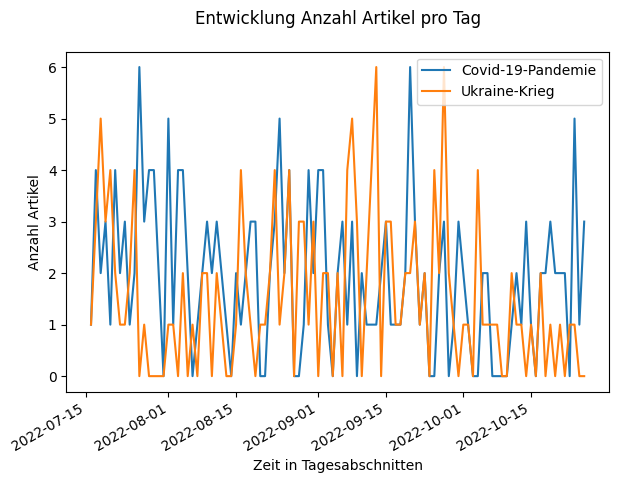

In [11]:
plt.style.use('default') # 'default' or 'dark_background'

fig, ax = plt.subplots()

ax = df_all_day.plot(kind="line", x="date", y=["Covid-19-Pandemie", "Ukraine-Krieg"], ax=ax, xlabel="Zeit in Tagesabschnitten", figsize=(7,5), ylabel="Anzahl Artikel")

ax.set_title(f'Entwicklung Anzahl Artikel pro Tag', pad=20)

fig.savefig(f'figures/bar-topics-trend-day.png')

## Erstelle ein abgerundetes Diagramm

In [12]:
#df_interpolation = create_interpolation_from(df_all_day, ucolumn='timestamp', columns=target)

In [13]:
#df_interpolation.plot(kind="line")

## 2. Gruppiere Artikel nach: Woche (eindeutig)

In [14]:
df_all = None

def week_year_to_timestamp(row):
    date = "{}-{}-1".format(row["year"], row["week"])
    return dt.strptime(date, "%Y-%W-%w").timestamp()

for topic in topics:
    # Betrachte nur die Artikel des aktuellen Themengebiets
    df_topic = df.loc[df.topic == topic]
    # Gruppiere die Artikel nach Woche (eindeutig) und aggregiere die Anzahl der Artikel pro Woche
    df_topic = df_topic.groupby(["week", "year"]).size().reset_index(name=topic)
    
    # Füge ein neues Feature hinzu: Datum
    df_topic['date'] = "KW " + df_topic['week'].astype(str) + " " + df_topic['year'].astype(str)
    df_topic['timestamp'] = df_topic.apply(week_year_to_timestamp, axis=1)

    # Lösche zwei Features: Woche, Jahr
    df_topic.drop(['week', 'year'], axis=1, inplace=True)

    # Falls der df der Gesamtdaten bereits Daten von vorherigen Themengebieten enthält, merge die Daten des aktuellen Themengebiets
    if (isinstance(df_all, pd.DataFrame)):
        df_all = pd.merge(df_all, df_topic, how='outer', on=["timestamp", "date"])
    # Initialisiere den df der Gesamtdaten mit den Daten des aktuellen Themengebiets
    else:
        df_all = df_topic


#### Fülle die leeren Felder mit der Anzahl 0

In [15]:
df_all = df_all.fillna(0)

#### Erstelle das Diagramm

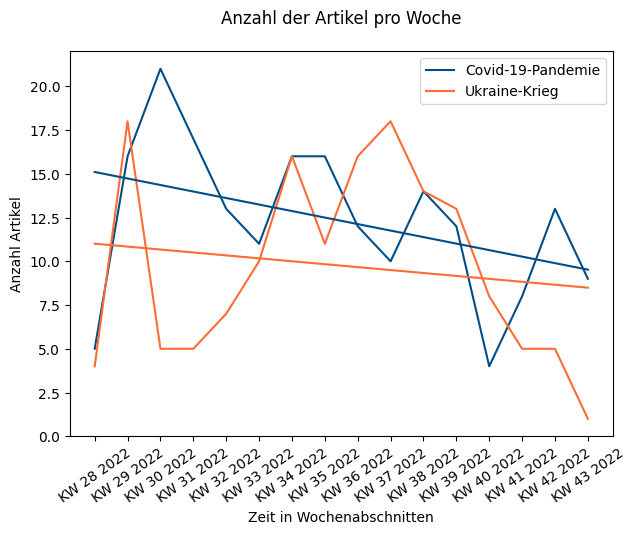

In [16]:
plt.style.use('default') # 'default' or 'dark_background'

fig, ax = plt.subplots()

color = ["#004e89", "#ff6b35", "#f7c59f", "#1a659e" ]

ax = df_all.plot(kind="line", x="timestamp", y=target, rot=35, color=color, ax=ax, xlabel="Zeit in Wochenabschnitten", figsize=(7,5), ylabel="Anzahl Artikel")

ax.set_xticks(df_all.timestamp.to_list())
ax.set_xticklabels(df_all.date)

plot_trendlines(df_all, on_axis=ax, ucolumn="timestamp", colors=color, columns=target)

ax.set_title(f'Anzahl der Artikel pro Woche', pad=20)

fig.savefig(f'figures/bar-topics-trend-week-all.png')

In [26]:
df_interpolation = create_interpolation_from(df_all, ucolumn='timestamp', columns=target)

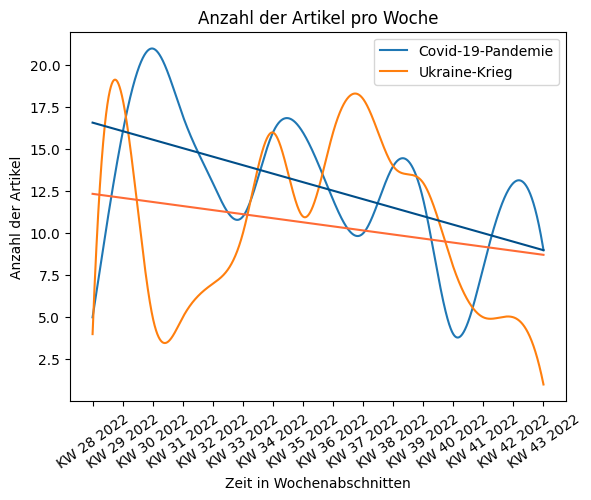

In [28]:
ax = df_interpolation.plot(kind="line", x='timestamp', rot=35, y=target, title="Anzahl der Artikel pro Woche", ylabel="Anzahl der Artikel", xlabel="Zeit in Wochenabschnitten")

ax.set_xticks(df_all.timestamp.to_list())
ax.set_xticklabels(df_all.date)

plot_trendlines(df_interpolation, on_axis=ax, ucolumn="timestamp", colors=color, columns=target)